# Implementing IPP in a Simulated GP Environment
This notebook is intended for to serve as a GP playground for different informative path planning algorithms.

Please note, that you may need to install the following in order to play with the [dubins library](https://github.com/AndrewWalker/Dubins-Curves) and the [Gaussian Process model](https://github.com/SheffieldML/GPy) respectively:

```pip install dubins
pip install GPy```

Also please note that this notebook is DEPRECATED.

This library allows for the generation of a Gaussian environment with known kernel parameter and provides an point-robot interface for planning informative paths through this initially unknown environment, while collecting noisy samples of the phenonema of interest from the environment. The robot's trajectories are represented as concatonations of dubins curves, assuming that the turning radius is known. 

In [1]:
# Necessary imports
%matplotlib inline

from matplotlib import pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib import cm
from sklearn import mixture
from IPython.display import display
from scipy.stats import multivariate_normal
import numpy as np
import math
import os
import GPy as GPy
import dubins
import time
from itertools import chain

## The GPModel Class
This custom GPModel class is the model representation used to generate a simulated Gaussian environment, and also used to represent the robot's current model of the environment. The class is a wrapper on to of the GPy library that allows for some additional features, including:
* Saving and loading trained kernel parameters
* Initializing a GP model without any prior data and adding new sample points
* Incrementally addding sample points to a previous dataset, resuing previous computation [TODO]
* Sparse, streaming GP posterior updates [TODO]

## The Squared Exponential Kernel

The GPModel currently assumes a Squared Exponential Kernel. Here is a guide to what the differnt kernel hyperparmeters mean, from [this post](http://evelinag.com/Ariadne/covarianceFunctions.html). 

\begin{equation}
\kappa(x_i, x_j) = \sigma^2 \text{exp}\Big(- \frac{(x_i - x_j)^2}{2l^2}\Big) + \sigma_{\text{noise}}^2
\end{equation} 

where $\sigma^2 > 0$ is the signal variance, $l>0$ is the lengthscale and $\sigma_{\text{noise}}^2>=0$ is the noise covariance. The noise variance is applied only when $i=j$.

Squared exponential is appropriate for modelling very smooth functions. The parameters have the following interpretation:

* **Lengthscale $l$** describes how smooth a function is. Small lengthscale value means that function values can change quickly, large values characterize functions that change only slowly. Lengthscale also determines how far we can reliably extrapolate from the training data.

* **Signal variance $\sigma^2$** is a scaling factor. It determines variation of function values from their mean. Small value of $\sigma^2$ characterize functions that stay close to their mean value, larger values allow more variation. If the signal variance is too large, the modelled function will be free to chase outliers.

* **Noise variance** $\sigma_{\text{noise}}^2$ is formally not a part of the covariance function itself. It is used by the Gaussian process model to allow for noise present in training data. This parameter specifies how much noise is expected to be present in the data.

In [2]:
class GPModel:
    '''The GPModel class, which is a wrapper on top of GPy, allowing saving and loading of trained kernel parameters.
    Inputs:
    * variance (float) the variance parameter of the squared exponential kernel
    * lengthscale (float) the lengthscale parameter of the squared exponential kernel
    * noise (float) the sensor noise parameter of the squared exponential kernel
    * dimension (float) the dimension of the environment (currently, only 2D environments are supported)
    * kernel (string) the type of kernel (currently, only 'rbf' kernels are supported) '''     
    
    def __init__(self, lengthscale, variance, noise = 0.05, dimension = 2, kernel = 'rbf'):
        '''Initialize a GP regression model with given kernel parameters. '''
        
        # The noise parameter of the sensor
        self.noise = noise
        self.lengthscale = lengthscale
        self.variance = variance
        
        # The Gaussian dataset
        self.xvals = None
        self.zvals = None
        
        # The dimension of the evironment
        if dimension == 2:
            self.dim = dimension
        else:
            raise ValueError('Environment must have dimension 2 \'rbf\'')

        if kernel == 'rbf':
            self.kern = GPy.kern.RBF(input_dim = self.dim, lengthscale = lengthscale, variance = variance) 
        else:
            raise ValueError('Kernel type must by \'rbf\'')
            
        # Intitally, before any data is created, 
        self.model = None
         
    def predict_value(self, xvals):
        ''' Public method returns the mean and variance predictions at a set of input locations.
        Inputs:
        * xvals (float array): an nparray of floats representing observation locations, with dimension NUM_PTS x 2
        
        Returns: 
        * mean (float array): an nparray of floats representing predictive mean, with dimension NUM_PTS x 1         
        * var (float array): an nparray of floats representing predictive variance, with dimension NUM_PTS x 1 '''        

        assert(xvals.shape[0] >= 1)            
        assert(xvals.shape[1] == self.dim)    
        
        n_points, input_dim = xvals.shape
        
        # With no observations, predict 0 mean everywhere and prior variance
        if self.model == None:
            return np.zeros((n_points, 1)), np.ones((n_points, 1)) * self.variance
        
        # Else, return 
        mean, var = self.model.predict(xvals, full_cov = False, include_likelihood = True)
        return mean, var        
    

    def set_data(self, xvals, zvals):
        ''' Public method that updates the data in the GP model.
        Inputs:
        * xvals (float array): an nparray of floats representing observation locations, with dimension NUM_PTS x 2
        * zvals (float array): an nparray of floats representing sensor observations, with dimension NUM_PTS x 1 ''' 
        
        # Save the data internally
        self.xvals = xvals
        self.zvals = zvals
        
        # If the model hasn't been created yet (can't be created until we have data), create GPy model
        if self.model == None:
            self.model = GPy.models.GPRegression(np.array(xvals), np.array(zvals), self.kern)
        # Else add to the exisiting model
        else:
            self.model.set_XY(X = np.array(xvals), Y = np.array(zvals))
    
    def add_data(self, xvals, zvals):
        ''' Public method that adds data to an the GP model.
        Inputs:
        * xvals (float array): an nparray of floats representing observation locations, with dimension NUM_PTS x 2
        * zvals (float array): an nparray of floats representing sensor observations, with dimension NUM_PTS x 1 ''' 
        
        if self.xvals is None:
            self.xvals = xvals
        else:
            self.xvals = np.vstack([self.xvals, xvals])
            
        if self.zvals is None:
            self.zvals = zvals
        else:
            self.zvals = np.vstack([self.zvals, zvals])

        # If the model hasn't been created yet (can't be created until we have data), create GPy model
        if self.model == None:
            self.model = GPy.models.GPRegression(np.array(xvals), np.array(zvals), self.kern)
#             self.model.optimize()
        # Else add to the exisiting model
        else:
            self.model.set_XY(X = np.array(self.xvals), Y = np.array(self.zvals))
#             self.model.optimize()

    def load_kernel(self, kernel_file = 'kernel_model.npy'):
        ''' Public method that loads kernel parameters from file.
        Inputs:
        * kernel_file (string): a filename string with the location of the kernel parameters '''    
        
        # Read pre-trained kernel parameters from file, if avaliable and no training data is provided
        if os.path.isfile(kernel_file):
            print "Loading kernel parameters from file"
            self.kern[:] = np.load(kernel_file)
        else:
            raise ValueError("Failed to load kernel. Kernel parameter file not found.")
            
        return

    def train_kernel(self, xvals = None, zvals = None, kernel_file = 'kernel_model.npy'):
        ''' Public method that optmizes kernel parameters based on input data and saves to files.
        Inputs:
        * xvals (float array): an nparray of floats representing observation locations, with dimension NUM_PTS x 2
        * zvals (float array): an nparray of floats representing sensor observations, with dimension NUM_PTS x 1        
        * kernel_file (string): a filename string with the location to save the kernel parameters '''      
        
        # Read pre-trained kernel parameters from file, if avaliable and no training data is provided
        if xvals is not None and zvals is not None:
            print "Optimizing kernel parameters given data"
            # Initilaize a GP model (used only for optmizing kernel hyperparamters)
            self.m = GPy.models.GPRegression(np.array(xvals), np.array(zvals), self.kern)
            self.m.initialize_parameter()

            # Constrain the hyperparameters during optmization
            self.m.constrain_positive('')
            #self.m['rbf.variance'].constrain_bounded(0.01, 10)
            #self.m['rbf.lengthscale'].constrain_bounded(0.01, 10)
            self.m['Gaussian_noise.variance'].constrain_fixed(self.noise)

            # Train the kernel hyperparameters
            self.m.optimize_restarts(num_restarts = 2, messages = True)

            # Save the hyperparemters to file
            np.save(kernel_file, self.kern[:])
        else:
            raise ValueError("Failed to train kernel. No training data provided.")
            
    def visualize_model(self, x1lim, x2lim, title = ''):
        if self.model is None:
            print 'No samples have been collected. World model is equivalent to prior.'
            return None
        else:
            print "Sample set size:", self.xvals.shape
            fig = self.model.plot(figsize=(4, 3), title = title, xlim = x1lim, ylim = x2lim)
            
    def kernel_plot(self):
        ''' Visualize the learned GP kernel '''        
        _ = self.kern.plot()
        plt.ylim([-10, 10])
        plt.xlim([-10, 10])
        plt.show()

## The Environment Class
This custom Environment class is used to represent environments of interest. Currently, the enviroment is constrained to be a rectangular region in $\mathbb{R}^2$. Upon initialization, the Environment class draws a random function from a Gaussian Process with the input covariance function. The Environment has one public method, ``sample_value``, which returns a noisy sample of the function value at a specified location. 


In [3]:
class Environment:
    '''The Environment class, which represents a retangular Gaussian world.
    
    Input:
    * ranges (tuple of floats): a tuple representing the max/min of 2D rectangular domain i.e. (-10, 10, -50, 50)
    * NUM_PTS (int): the number of points in each dimension to sample for initialization, 
                    resulting in a sample grid of size NUM_PTS x NUM_PTS
    * variance (float): the variance parameter of the squared exponential kernel
    * lengthscale (float): the lengthscale parameter of the squared exponential kernel
    * noise (float): the sensor noise parameter of the squared exponential kernel
    * visualize (boolean): a boolean flag to plot the surface of the resulting environment 
    * seed (int): an integer seed for the random draws. If set to \'None\', no seed is used ''' 

    def __init__(self, ranges, NUM_PTS, variance = 0.5, lengthscale = 1.0, noise = 0.05, visualize = True, seed = None, dim = 2):
        ''' Initialize a random Gaussian environment using the input kernel, assuming zero mean'''
        # Save the parmeters of GP model
        self.variance = variance
        self.lengthscale = lengthscale
        self.dim = dim
        
        # Expect ranges to be a 4-tuple consisting of x1min, x1max, x2min, and x2max
        self.x1min = float(ranges[0])
        self.x1max = float(ranges[1])
        self.x2min = float(ranges[2])
        self.x2max = float(ranges[3]) 
        
        # Intialize a GP model of the environment
        self.GP = GPModel(lengthscale = lengthscale, variance = variance)         
                            
        # Generate a set of discrete grid points, uniformly spread across the environment
        x1 = np.linspace(self.x1min, self.x1max, NUM_PTS)
        x2 = np.linspace(self.x2min, self.x2max, NUM_PTS)
        x1vals, x2vals = np.meshgrid(x1, x2, sparse = False, indexing = 'xy') # dimension: NUM_PTS x NUM_PTS
        data = np.vstack([x1vals.ravel(), x2vals.ravel()]).T # dimension: NUM_PTS*NUM_PTS x 2

        # Take an initial sample in the GP prior, conditioned on no other data
        xsamples = np.reshape(np.array(data[0, :]), (1, dim)) # dimension: 1 x 2        
        mean, var = self.GP.predict_value(xsamples)   
        
        if seed is not None:
            np.random.seed(seed)
            seed += 1
        zsamples = np.random.normal(loc = mean, scale = np.sqrt(var))
        zsamples = np.reshape(zsamples, (1,1)) # dimension: 1 x 1 
                            
        # Add new data point to the GP model
        self.GP.set_data(xsamples, zsamples)                            
                                 
        # Iterate through the rest of the grid sequentially and sample a z values, condidtioned on previous samples
        for index, point in enumerate(data[1:, :]):
            # Get a new sample point
            xs = np.reshape(np.array(point), (1, dim))
    
            # Compute the predicted mean and variance
            mean, var = self.GP.predict_value(xs)
            
            # Sample a new observation, given the mean and variance
            if seed is not None:
                np.random.seed(seed)
                seed += 1            
            zs = np.random.normal(loc = mean, scale = np.sqrt(var))
            
            # Add new sample point to the GP model
            zsamples = np.vstack([zsamples, np.reshape(zs, (1, 1))])
            xsamples = np.vstack([xsamples, np.reshape(xs, (1, dim))])
            self.GP.set_data(xsamples, zsamples)
      
        # Plot the surface mesh and scatter plot representation of the samples points
        if visualize == True:
            fig = plt.figure(figsize=(4, 3))
            ax = fig.add_subplot(111, projection = '3d')
            ax.set_title('Surface of the Simulated Environment')
            surf = ax.plot_surface(x1vals, x2vals, zsamples.reshape(x1vals.shape), cmap = cm.coolwarm, linewidth = 1)

            #ax2 = fig.add_subplot(212, projection = '3d')
            
            fig2 = plt.figure(figsize=(4, 3))
            ax2 = fig2.add_subplot(111)
            ax2.set_title('Countour Plot of the Simulated Environment')     
            plot = ax2.contourf(x1vals, x2vals, zsamples.reshape(x1vals.shape), cmap = 'viridis')
            scatter = ax2.scatter(data[:, 0], data[:, 1], c = zsamples.ravel(), s = 4.0, cmap = 'viridis')            
            plt.show()           
        
        print "Environment initialized with bounds X1: (", self.x1min, ",", self.x1max, ")  X2:(", self.x2min, ",", self.x2max, ")" 
      
    def sample_value(self, xvals):
        ''' The public interface to the Environment class. Returns a noisy sample of the true value of environment 
        at a set of point. 
        Input:
        * xvals (float array): an nparray of floats representing observation locations, with dimension NUM_PTS x 2 
        
        Returns:
        * mean (float array): an nparray of floats representing predictive mean, with dimension NUM_PTS x 1 '''
        assert(xvals.shape[0] >= 1)            
        assert(xvals.shape[1] == self.dim)        
        mean, var = self.GP.predict_value(xvals)
        return mean
    

## Representing Path Sets: Path Generator Classes
This custom class leverages some of the nice features of the ```dubins``` library to generate a number of options and sample sets for the vehicle to choose from.

In [4]:
class Path_Generator:
    '''The Path_Generator class which creates naive point-to-point straightline paths'''
    
    def __init__(self, frontier_size, horizon_length, turning_radius, sample_step, extent):
        '''
        frontier_size (int) the number of points on the frontier we should consider for navigation
        horizon_length (float) distance between the vehicle and the horizon to consider
        turning_radius (float) the feasible turning radius for the vehicle
        sample_step (float) the unit length along the path from which to draw a sample
        '''

        self.fs = frontier_size
        self.hl = horizon_length
        self.tr = turning_radius
        self.ss = sample_step
        self.extent = extent

        # Global variables
        self.goals = [] #The frontier coordinates
        self.samples = {} #The sample points which form the paths
        self.cp = (0,0,0) #The current pose of the vehicle
        
    def generate_frontier_points(self):
        '''From the frontier_size and horizon_length, generate the frontier points to goal'''
        angle = np.linspace(-2.35,2.35,self.fs) #fix the possibilities to 75% of the unit circle, ignoring points directly behind the vehicle
        goals = [(self.hl*np.cos(self.cp[2]+a)+self.cp[0], self.hl*np.sin(self.cp[2]+a)+self.cp[1], self.cp[2]+a) for a in angle]
        self.goals = goals#[coordinate for coordinate in goals if coordinate[0] < self.extent[1] and coordinate[0] > self.extent[0] and coordinate[1] < self.extent[3] and coordinate[1] > self.extent[2]]
        return self.goals
        
    def make_sample_paths(self):
        '''Connect the current_pose to the goal places'''
        cp = np.array(self.cp)
        coords = {}
        for i,goal in enumerate(self.goals):
            g = np.array(goal)
            distance = np.sqrt((cp[0]-g[0])**2 + (cp[1]-g[1])**2)
            samples = int(round(distance/self.ss))
            
            # Don't include the start location but do include the end point
            for j in range(0,samples):
                x = cp[0]+((j+1)*self.ss)*np.cos(g[2])
                y = cp[1]+((j+1)*self.ss)*np.sin(g[2])
                a = g[2]
                try: 
                    coords[i].append((x,y,a))
                except:
                    coords[i] = []
                    coords[i].append((x,y,a))
        self.samples = coords
        return coords
    
    def get_path_set(self, current_pose):
        '''Primary interface for getting list of path sample points for evaluation'''
        self.cp = current_pose
        self.generate_frontier_points()
        paths = self.make_sample_paths()
        return paths
    
    def get_frontier_points(self):
        return self.goals
    
    def get_sample_points(self):
        return self.samples

In [5]:
class Dubins_Path_Generator(Path_Generator):
    '''
    The Dubins_Path_Generator class, which inherits from the Path_Generator class. Replaces the make_sample_paths
    method with paths generated using the dubins library
    '''
        
    def make_sample_paths(self):
        '''Connect the current_pose to the goal places'''
        coords = {}
        for i,goal in enumerate(self.goals):
            g = (goal[0],goal[1],self.cp[2])
            path = dubins.shortest_path(self.cp, goal, self.tr)
            configurations, _ = path.sample_many(self.ss)
            coords[i] = [config for config in configurations if config[0] > self.extent[0] and config[0] < self.extent[1] and config[1] > self.extent[2] and config[1] < self.extent[3]]
        
        self.samples = coords
        return coords

In [6]:
class Dubins_EqualPath_Generator(Path_Generator):
    '''
    The Dubins_EqualPath_Generator class which inherits from Path_Generator. Modifies Dubin Curve paths so that all
    options have an equal number of sampling points
    '''
        
    def make_sample_paths(self):
        '''Connect the current_pose to the goal places'''
        coords = {}
        for i,goal in enumerate(self.goals):
            g = (goal[0],goal[1],self.cp[2])
            path = dubins.shortest_path(self.cp, goal, self.tr)
            configurations, _ = path.sample_many(self.ss)
            coords[i] = [config for config in configurations if config[0] > self.extent[0] and config[0] < self.extent[1] and config[1] > self.extent[2] and config[1] < self.extent[3]]
        
        # find the "shortest" path in sample space
        current_min = 1000
        for key,path in coords.items():
            if len(path) < current_min and len(path) > 1:
                current_min = len(path)
        
        # limit all paths to the shortest path in sample space
        for key,path in coords.items():
            if len(path) > current_min:
                path = path[0:current_min]
                coords[key]=path
        
        self.samples = coords
        return coords

## The Evaluation Class
This custom Evaluation class store performance metrics for the robot during mission execution. It is initialized with a ground truth world model, which is used only for the purpous of real-time performance tracking. The Evaluation class includes a variety of differnt evaluation metrics.

### The Model: 
We have some ground truth scalar, stationary function $m: \mathbb{X} \to \mathbb{R}$ e.g. methane concentration, temperature, etc. We place a GP prior on the unknown function $m$ with mean $\mu$ and covariance function $\kappa$:
$$ m \sim \mathcal{GP}(\mu, \kappa) $$

We define a reward function $f: 2^{\mathbb{X}} \to \mathbb{R}$ that quantifies the true reward of a robot being in a set of states $\mathcal{A} \subset \mathbb{X}$:
$$ f(\mathcal{A}) = IG(m; \mathcal{A}) + \lambda \sum_{\mathbf{x} \in \mathcal{A}} m(\mathbf{x}) $$
where $IG: 2^{\mathbb{X}} \to \mathbb{R}$ is the information gain of a set of points with respect to the underlying function $m$.

We also define an aquisition function $\alpha: 2^{\mathbb{X}} \to \mathbb{R}$, by which the robot can select promising trajectories:
$$ \alpha(\mathcal{A}) = f(\mathcal{A}) + \beta_t \sum_{\mathbf{x} \in \mathcal{A}} \sigma_{t-1}(\mathbf{x})$$
$$ \alpha(\mathcal{A}) = IG(m; \mathcal{A}) + \lambda \sum_{\mathbf{x} \in \mathcal{A}} \mu_{t-1}(\mathbf{x}) + \beta_t \lambda \sum_{\mathbf{x} \in \mathcal{A}} \sigma_{t-1}(\mathbf{x})$$

Here is an outline of the metrics:

* Information Gain $\mathcal{I}(m; \mathbf{y}_A \mid \mathbf{y}_{obs})$: The mutual information between a set of potential observations $\mathbf{y}_A$ and the underlying function $m$, given a set of previous observations $\mathbf{y}_{obs}$.


In [7]:
class Evaluation:
    def __init__(self, world, reward_function = 'mean'):
        self.world = world
        
        self.metrics = {'aquisition_function': {},
                        'mean_reward': {}, 
                        'info_gain_reward': {},                         
                        'hotspot_info_reward': {}, 
                        'MSE': {},                         
                        'instant_regret': {},                        
                       }
        
        self.reward_function = reward_function
        
        if reward_function == 'hotspot_info':
            self.f_rew = self.hotspot_info_reward
            self.f_aqu = hotspot_info_UCB
        elif reward_function == 'mean':
            self.f_rew = self.mean_reward
            self.f_aqu = mean_UCB      
        elif reward_function == 'info_gain':
            self.f_rew = self.info_gain_reward
            self.f_aqu = info_gain             
        else:
            raise ValueError('Only \'mean\' and \'hotspot_info\' reward functions currently supported.')    
    
    ''' %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                Reward Functions - should have the form:
    def reward(time, xvals), where:
    * time (int): the current timestep of planning
    * xvals (list of float tuples): representing a path i.e. [(3.0, 4.0), (5.6, 7.2), ... ])
    * robot_model (GPModel)
    
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%'''
    def mean_reward(self, time, xvals, robot_model):
        ''' Predcited mean (true) reward function'''
        data = np.array(xvals)
        x1 = data[:,0]
        x2 = data[:,1]
        queries = np.vstack([x1, x2]).T   
        
        mu, var = self.world.GP.predict_value(queries)
        return np.sum(mu)   


    def hotspot_info_reward(self, time, xvals, robot_model):
        ''' The reward information gathered plus the exploitation value gathered'''    
        LAMBDA = 0.5
        data = np.array(xvals)
        x1 = data[:,0]
        x2 = data[:,1]
        queries = np.vstack([x1, x2]).T   
        
        mu, var = self.world.GP.predict_value(queries)    
        return self.info_gain_reward(time, xvals, robot_model) + LAMBDA * np.sum(mu)
    
    def info_gain_reward(self, time, xvals, robot_model):
        ''' The information reward gathered '''
        return info_gain(time, xvals, robot_model)
    
    ''' %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                               End Reward Functions
        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%'''        
    def inst_regret(self, t, all_paths, selected_path, robot_model):
        ''' The instantaneous Kapoor regret of a selected path, according to the specified reward function
        Input:
        * all_paths: the set of all avalaible paths to the robot at time t
        * selected path: the path selected by the robot at time t '''
        
        value_omni = {}        
        for path, points in all_paths.items():           
            value_omni[path] =  self.f_rew(time = t, xvals = points, robot_model = robot_model)  
        value_max = value_omni[max(value_omni, key = value_omni.get)]
        
        value_selected = self.f_rew(time = t, xvals = selected_path, robot_model = robot_model)

        #assert(value_max - value_selected >= 0)
        return value_max - value_selected
        
    def MSE(self, robot_model, NTEST = 10):
        ''' Compute the MSE on a set of test points, randomly distributed throughout the environment'''
        np.random.seed(0)
        x1 = np.random.random_sample((NTEST, 1)) * (self.world.x1max - self.world.x1min) + self.world.x1min
        x2 = np.random.random_sample((NTEST, 1)) * (self.world.x2max - self.world.x2min) + self.world.x2min
        data = np.hstack((x1, x2))
        
        pred_world, var_world = self.world.GP.predict_value(data)
        pred_robot, var_robot = robot_model.predict_value(data)      
        
        return ((pred_world - pred_robot) ** 2).mean()
    
    def update_metrics(self, t, robot_model, all_paths, selected_path):
        ''' Function to update avaliable metrics'''    
        # Compute aquisition function
        self.metrics['aquisition_function'][t] = self.f_aqu(t, selected_path, robot_model)
        
        # Compute reward functions
        self.metrics['mean_reward'][t] = self.mean_reward(t, selected_path, robot_model)
        self.metrics['info_gain_reward'][t] = self.info_gain_reward(t, selected_path, robot_model)
        self.metrics['hotspot_info_reward'][t] = self.hotspot_info_reward(t, selected_path, robot_model)
        
        # Compute other performance metrics
        self.metrics['MSE'][t] = self.MSE(robot_model, NTEST = 25)
        self.metrics['instant_regret'][t] = self.inst_regret(t, all_paths, selected_path, robot_model)
    
    def plot_metrics(self):
        # Asumme that all metrics have the same time as MSE; not necessary
        time = np.array(self.metrics['MSE'].keys())
        
        ''' Metrics that require a ground truth global model to compute'''        
        MSE = np.array(self.metrics['MSE'].values())
        regret = np.cumsum(np.array(self.metrics['instant_regret'].values()))
        mean = np.cumsum(np.array(self.metrics['mean_reward'].values()))
        hotspot_info = np.cumsum(np.array(self.metrics['hotspot_info_reward'].values()))
        
        ''' Metrics that the robot can compute online '''
        info_gain = np.cumsum(np.array(self.metrics['info_gain_reward'].values()))        
        UCB = np.cumsum(np.array(self.metrics['aquisition_function'].values()))
        
        fig, ax = plt.subplots(figsize=(4, 3))
        ax.set_title('Accumulated UCB Aquisition Function')             
        plt.plot(time, UCB, 'g')
        
        fig, ax = plt.subplots(figsize=(4, 3))
        ax.set_title('Accumulated Information Gain')                             
        plt.plot(time, info_gain, 'k')        
        
        fig, ax = plt.subplots(figsize=(4, 3))
        ax.set_title('Accumulated Mean Reward')                     
        plt.plot(time, mean, 'b')      
        
        fig, ax = plt.subplots(figsize=(4, 3))
        ax.set_title('Accumulated Hotspot Information Gain Reward')                             
        plt.plot(time, hotspot_info, 'r')          
        
        fig, ax = plt.subplots(figsize=(4, 3))
        ax.set_title('Average Regret w.r.t. ' + self.reward_function + ' Reward')                     
        plt.plot(time, regret/time, 'b')        
        
        fig, ax = plt.subplots(figsize=(4, 3))
        ax.set_title('Map MSE at 100 Random Test Points')                             
        plt.plot(time, MSE, 'r')  
   
        plt.show()          
    
                             
'''%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    Aquisition Functions - should have the form:
    def alpha(time, xvals, robot_model), where:
    * time (int): the current timestep of planning
    * xvals (list of float tuples): representing a path i.e. [(3.0, 4.0), (5.6, 7.2), ... ])
    * robot_model (GPModel object): the robot's current model of the environment
    
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% '''

def info_gain(time, xvals, robot_model):
    ''' Compute the information gain of a set of potential sample locations with respect to the underlying fucntion
        conditioned or previous samples xobs'''        
    data = np.array(xvals)
    x1 = data[:,0]
    x2 = data[:,1]
    queries = np.vstack([x1, x2]).T   
    xobs = robot_model.xvals

    # If the robot hasn't taken any observations yet, simply return the entropy of the potential set
    if xobs is None:
        Sigma_after = robot_model.kern.K(queries)
        entropy_after, sign_after = np.linalg.slogdet(np.eye(Sigma_after.shape[0], Sigma_after.shape[1]) \
                                    + robot_model.variance * Sigma_after)
        #print "Entropy with no obs: ", entropy_after
        return 0.5 * sign_after * entropy_after

    all_data = np.vstack([xobs, queries])
    
    # The covariance matrices of the previous observations and combined observations respectively
    Sigma_before = robot_model.kern.K(xobs) 
    Sigma_total = robot_model.kern.K(all_data)       

    # The term H(y_a, y_obs)
    entropy_before, sign_before =  np.linalg.slogdet(np.eye(Sigma_before.shape[0], Sigma_before.shape[1]) \
                                    + robot_model.variance * Sigma_before)
    
    # The term H(y_a, y_obs)
    entropy_after, sign_after = np.linalg.slogdet(np.eye(Sigma_total.shape[0], Sigma_total.shape[1]) \
                                    + robot_model.variance * Sigma_total)

    # The term H(y_a | f)
    entropy_total = 2 * np.pi * np.e * sign_after * entropy_after - 2 * np.pi * np.e * sign_before * entropy_before
    #print "Entropy: ", entropy_total


    ''' TODO: this term seems like it should still be in the equation, but it makes the IG negative'''
    #entropy_const = 0.5 * np.log(2 * np.pi * np.e * robot_model.variance)
    entropy_const = 0.0

    # This assert should be true, but it's not :(
    #assert(entropy_after - entropy_before - entropy_const > 0)
    return entropy_total - entropy_const

    
def mean_UCB(time, xvals, robot_model):
    ''' Computes the UCB for a set of points along a trajectory '''
    data = np.array(xvals)
    x1 = data[:,0]
    x2 = data[:,1]
    queries = np.vstack([x1, x2]).T   
                              
    # The GPy interface can predict mean and variance at an array of points; this will be an overestimate
    mu, var = robot_model.predict_value(queries)
    
    delta = 0.9
    d = 20
    pit = np.pi**2 * (time + 1)**2 / 6.
    beta_t = 2 * np.log(d * pit / delta)

    return np.sum(mu) + np.sqrt(beta_t) * np.sum(np.fabs(var))

def hotspot_info_UCB(time, xvals, robot_model):
    ''' The reward information gathered plus the exploitation value gathered'''
    data = np.array(xvals)
    x1 = data[:,0]
    x2 = data[:,1]
    queries = np.vstack([x1, x2]).T   
                              
    LAMBDA = 0.5
    mu, var = robot_model.predict_value(queries)
    
    delta = 0.9
    d = 20
    pit = np.pi**2 * (time + 1)**2 / 6.
    beta_t = 2 * np.log(d * pit / delta)

    return info_gain(time, xvals, robot_model) + LAMBDA * np.sum(mu) + np.sqrt(beta_t) * np.sum(np.fabs(var))
                              
                              


## The Monte Carlo Search Tree Class
For non-myopic horizons we select to use a Monte Carlo tree search in order to select an action plan in a global setting. We create a Monte Calro Search Tree class for convenience.

In [8]:
class MCTS():
    '''Class that establishes a MCTS for nonmyopic planning'''
    def __init__(self, computation_budget, belief, initial_pose, planning_limit, frontier_size, path_generator, aquisition_function, time):
        '''Initialize with constraints for the planning, including whether there is 
           a budget or planning horizon
           budget - length, time, etc to consider
           belief - GP model of the robot current belief state
           initial_pose - (x,y,rho) for vehicle'''
        self.budget = computation_budget
        self.GP = belief
        self.cp = initial_pose
        self.limit = planning_limit
        self.frontier_size = frontier_size
        self.path_generator = path_generator
        self.spent = 0
        self.tree = None
        self.aquisition_function = aquisition_function
        self.t = time

    def get_actions(self):
        self.tree = self.initialize_tree()
        time_start = time.clock()
        
        while time.clock() - time_start < self.budget:
            current_node = self.tree_policy()
            sequence = self.rollout_policy(current_node, self.budget)
            reward = self.get_reward(sequence)
            self.update_tree(reward, sequence)
        best_sequence, cost = self.get_best_child()
        return self.tree[best_sequence][0], cost

    def initialize_tree(self):
        '''Creates a tree instance, which is a dictionary, that keeps track of the nodes in the world'''
        tree = {}
        #(pose, number of queries)
        tree['root'] = (self.cp, 0)
        actions = self.path_generator.get_path_set(self.cp)
        for action, samples in actions.items():
            #(samples, cost, reward, number of times queried)
            cost = np.sqrt((self.cp[0]-samples[-1][0])**2 + (self.cp[1]-samples[-1][1])**2)
            tree['child '+ str(action)] = (samples, cost, 0, 0)
        return tree

    def tree_policy(self):
        '''Implements the UCB policy to select the child to expand and forward simulate'''
        # According to Arora:
        #avg_r average reward of all rollouts that have passed through node n
        #c_p some constant , 0.1 in literature
        #N number of times parent has been evaluated
        #n number of time node n has been evaluated
        #ucb = avg_r + c_p*np.sqrt(2*np.log(N)/n)
        leaf_eval = {}
        for i in xrange(self.frontier_size):
            node = 'child '+ str(i)
            leaf_eval[node] = self.tree[node][2] + 0.1*np.sqrt(2*(np.log(self.tree['root'][1]))/self.tree[node][3])
#         print max(leaf_eval, key=leaf_eval.get)
        return max(leaf_eval, key=leaf_eval.get)

    def rollout_policy(self, node, budget):
        '''Select random actions to expand the child node'''
        sequence = [node] #include the child node
        #TODO use the cost metric to signal action termination, for now using horizon
        for i in xrange(self.limit):
            actions = self.path_generator.get_path_set(self.tree[node][0][-1]) #plan from the last point in the sample
            a = np.random.randint(0,len(actions)) #choose a random path
            #TODO add cost metrics
#             best_path = actions[a]
#             if len(best_path) == 1:
#                 best_path = [(best_path[-1][0],best_path[-1][1],best_path[-1][2]-1.14)]
#             elif best_path[-1][0] < -9.5 or best_path[-1][0] > 9.5:
#                 best_path = (best_path[-1][0],best_path[-1][1],best_path[-1][2]-1.14)
#             elif best_path[-1][1] < -9.5 or best_path[-1][0] >9.5:s
#                 best_path = (best_path[-1][0],best_path[-1][1],best_path[-1][2]-1.14)
#             else:
#                 best_path = best_path[-1]
            self.tree[node + ' child ' + str(a)] = (actions[a], 0, 0, 0) #add random path to the tree
            node = node + ' child ' + str(a)
            sequence.append(node)
        return sequence #return the sequence of nodes that are made

    def get_reward(self, sequence):
        '''Evaluate the sequence to get the reward, defined by the percentage of entropy reduction'''
        # The process is iterated until the last node of the rollout sequence is reached 
        # and the total information gain is determined by subtracting the entropies 
        # of the initial and final belief space.
        # reward = infogain / Hinit (joint entropy of current state of the mission)
        sim_world = self.GP
        samples = []
        obs = []
        for seq in sequence:
            samples.append(self.tree[seq][0])
        obs = list(chain.from_iterable(samples))
        return self.aquisition_function(time = self.t, xvals = obs, robot_model = sim_world)
    
    def info_gain(self, xvals, robot_model):
        ''' Compute the information gain of a set of potential sample locations with respect to the underlying fucntion
            conditioned or previous samples xobs'''        
        data = np.array(xvals)
        x1 = data[:,0]
        x2 = data[:,1]
        queries = np.vstack([x1, x2]).T   
        xobs = robot_model.xvals

        # If the robot hasn't taken any observations yet, simply return the entropy of the potential set
        if xobs is None:
            Sigma_after = robot_model.kern.K(queries)
            entropy_after = 0.5 * np.log(np.linalg.det(np.eye(Sigma_after.shape[0], Sigma_after.shape[1]) \
                                        + robot_model.variance * Sigma_after))
            return (0.5*np.log(entropy_after), 0.5*(np.log(entropy_after)))

        all_data = np.vstack([xobs, queries])

        # The covariance matrices of the previous observations and combined observations respectively
        Sigma_before = robot_model.kern.K(xobs) 
        Sigma_total = robot_model.kern.K(all_data)       

        # The term H(y_a, y_obs)
        entropy_before = 2 * np.pi * np.e * np.linalg.det(np.eye(Sigma_before.shape[0], Sigma_before.shape[1]) \
                                        + robot_model.variance * Sigma_before)

        # The term H(y_a, y_obs)
        entropy_after = 2 * np.pi * np.e * np.linalg.det(np.eye(Sigma_total.shape[0], Sigma_total.shape[1]) \
                                        + robot_model.variance * Sigma_total)

        # The term H(y_a | f)
        entropy_total = 0.5 * np.log(entropy_after / entropy_before)

        ''' TODO: this term seems like it should still be in the equation, but it makes the IG negative'''
        #entropy_const = 0.5 * np.log(2 * np.pi * np.e * robot_model.variance)
        entropy_const = 0.0

        # This assert should be true, but it's not :(
        #assert(entropy_after - entropy_before - entropy_const > 0)
        #return entropy_total - entropsy_const
        return (entropy_total, 0.5*np.log(entropy_before))
    
    def update_tree(self, reward, sequence):
        '''Propogate the reward for the sequence'''
        #TODO update costs as well
        self.tree['root'] = (self.tree['root'][0], self.tree['root'][1]+1)
        for seq in sequence:
            samples, cost, rew, queries = self.tree[seq]
            queries += 1
            n = queries
            rew = ((n-1)*rew+reward)/n
            self.tree[seq] = (samples, cost, rew, queries)

    def get_best_child(self):
        '''Query the tree for the best child in the actions'''
        best = -1000
        best_child = None
        for i in xrange(self.frontier_size):
            r = self.tree['child '+ str(i)][2]
            if r > best:
                best = r
                best_child = 'child '+ str(i)
        return best_child, 0

## The Robot Class
This custom Robot class is used to represent a point robot with all of the requisite modeling and planning algortihms necessary to perform informative path planning in unknown Gaussian environments. The Robot class includes:
* A ``GPModel`` object, which represents the robot's current knowledge about the world, including prior information, kernel, and previously sampled points
* A ``sample_world`` function handel, which it allows it to aquire a noisy sample from the enviroment at a location/set of locations in the environment
* A [TODO] object, which represents the set of actions/paths avaliable to a robot from it's current pose
* A [TODO], which allows the robot to plan myopic trajectories
* A [TODO], which allows the robot to plan nonmyopic trajectories


In [10]:
class Robot:
    '''The Robot class, which includes the vehicles current model of the world, path set represetnation, and
        infromative path planning algorithm.
        
        * sample_world (method) a function handle that takes a set of locations as input and returns a set of observations
        * start_loc (tuple of floats) the location of the robot initially in 2-D space e.g. (0.0, 0.0)
        * ranges (tuple of floats): a tuple representing the max/min of 2D rectangular domain i.e. (-10, 10, -50, 50)
        * kernel_file (string) a filename specifying the location of the stored kernel values
        * kernel_dataset (tuple of nparrays) a tuple (xvals, zvals), where xvals is a Npoint x 2 nparray of type float
            and zvals is a Npoint x 1 nparray of type float 
        * prior_dataset (tuple of nparrays) a tuple (xvals, zvals), where xvals is a Npoint x 2 nparray of type float
            and zvals is a Npoint x 1 nparray of type float                
        * init_variance (float) the variance parameter of the squared exponential kernel
        * init_lengthscale (float) the lengthscale parameter of the squared exponential kernel
        * noise (float) the sensor noise parameter of the squared exponential kernel '''
    
    def __init__(self, sample_world, start_loc = (0.0, 0.0, 0.0), ranges = (-10., 10., -10., 10.), kernel_file = None, 
            kernel_dataset = None, prior_dataset = None, init_lengthscale = 10.0, init_variance = 100.0, noise = 0.05, 
            path_generator = 'default', frontier_size = 6, horizon_length = 5, turning_radius = 1, sample_step = 0.5, 
            evaluation = None, f_rew = 'mean'):
        ''' Initialize the robot class with a GP model, initial location, path sets, and prior dataset'''
        self.ranges = ranges
        self.eval = evaluation
        self.loc = start_loc # Initial location of the robot      
        self.sample_world = sample_world # A function handel that allows the robot to sample from the environment 
        
        if f_rew == 'hotspot_info':
            self.aquisition_function = hotspot_info_UCB
        elif f_rew == 'mean':
            self.aquisition_function = mean_UCB  
        elif f_rew == 'info_gain':
            self.aquisition_function = info_gain
        else:
            raise ValueError('Only \'hotspot_info\' and \'mean\' and \'info_gain\' reward fucntions supported.')

        # Initialize the robot's GP model with the initial kernel parameters
        self.GP = GPModel(lengthscale = init_lengthscale, variance = init_variance)
                
        # If both a kernel training dataset and a prior dataset are provided, train the kernel using both
        if  kernel_dataset is not None and prior_dataset is not None:
            data = np.vstack([prior_dataset[0], kernel_dataset[0]])
            observations = np.vstack([prior_dataset[1], kernel_dataset[1]])
            self.GP.train_kernel(data, observations, kernel_file) 
        # Train the kernel using the provided kernel dataset
        elif kernel_dataset is not None:
            self.GP.train_kernel(kernel_dataset[0], kernel_dataset[1], kernel_file)
        # If a kernel file is provided, load the kernel parameters
        elif kernel_file is not None:
            self.GP.load_kernel()
        # No kernel information was provided, so the kernel will be initialized with provided values
        else:
            pass
        
        # Incorporate the prior dataset into the model
        if prior_dataset is not None:
            self.GP.set_data(prior_dataset[0], prior_dataset[1]) 
        
        # The path generation class for the robot
        path_options = {'default':Path_Generator(frontier_size, horizon_length, turning_radius, sample_step, ranges),
                        'dubins': Dubins_Path_Generator(frontier_size, horizon_length, turning_radius, sample_step, ranges),
                        'equal_dubins': Dubins_EqualPath_Generator(frontier_size, horizon_length, turning_radius, sample_step, ranges)}
        self.path_generator = path_options[path_generator]
        
    def visualize_world_model(self):
        ''' Visaulize the robots current world model by sampling points uniformly in space and plotting the predicted
            function value at those locations. '''
        # Generate a set of observations from robot model with which to make contour plots
        x1vals = np.linspace(self.ranges[0], self.ranges[1], 100)
        x2vals = np.linspace(self.ranges[2], self.ranges[3], 100)
        x1, x2 = np.meshgrid(x1vals, x2vals, sparse = False, indexing = 'xy') # dimension: NUM_PTS x NUM_PTS       
        data = np.vstack([x1.ravel(), x2.ravel()]).T
        observations, var = self.GP.predict_value(data)        
        
        fig2 = plt.figure(figsize=(4, 3))
        ax2 = fig2.add_subplot(111)
        ax2.set_xlim(self.ranges[0:2])
        ax2.set_ylim(self.ranges[2:])        
        ax2.set_title('Countour Plot of the Robot\'s World Model')     
    
        plot = ax2.contourf(x1, x2, observations.reshape(x1.shape), cmap = 'viridis')
        # Plot the samples taken by the robot
        scatter = ax2.scatter(self.GP.xvals[:, 0], self.GP.xvals[:, 1], c = self.GP.zvals.ravel(), s = 10.0, cmap = 'viridis')        
        plt.show()           

    def choose_trajectory(self, T, t):
        ''' Select the best trajectory avaliable to the robot at the current pose, according to the aquisition function.
        Input: 
        * T (int > 0): the length of the planning horization (number of planning iterations) 
        * t (int > 0): the current planning iteration (value of a point can change with algortihm progress)'''
        paths = self.path_generator.get_path_set(self.loc)
        value = {}        

        for path, points in paths.items():
            value[path] =  self.aquisition_function(time = t, xvals = points, robot_model = self.GP)            
        try:
            return paths[max(value, key = value.get)], value[max(value, key = value.get)], paths
        except:
            return None
    
    def collect_observations(self, xobs):
        ''' Gather noisy samples of the environment and updates the robot's GP model.
        Input: 
        * xobs (float array): an nparray of floats representing observation locations, with dimension NUM_PTS x 2 '''
        zobs = self.sample_world(xobs)       
        self.GP.add_data(xobs, zobs)

    def myopic_planner(self, T):
        ''' Gather noisy samples of the environment and updates the robot's GP model  
        Input: 
        * T (int > 0): the length of the planning horization (number of planning iterations)'''
        self.trajectory = []
        
        for t in xrange(T):
            # Select the best trajectory according to the robot's aquisition function
            best_path, best_val, all_paths = self.choose_trajectory(T = T, t = t)
            
            # Given this choice, update the evaluation metrics 
            self.eval.update_metrics(t, self.GP, all_paths, best_path)            
            
            if best_path == None:
                break
            data = np.array(best_path)
            x1 = data[:,0]
            x2 = data[:,1]
            xlocs = np.vstack([x1, x2]).T           
            
            if len(best_path) != 1:
                self.collect_observations(xlocs)
                
            self.trajectory.append(best_path)
            
            if len(best_path) == 1:
                self.loc = (best_path[-1][0], best_path[-1][1], best_path[-1][2]-0.45)
            else:
                self.loc = best_path[-1]
    
    def visualize_trajectory(self):      
        ''' Visualize the set of paths chosen by the robot '''
        fig, ax = plt.subplots(figsize=(4, 3))
        ax.set_xlim(self.ranges[0:2])
        ax.set_ylim(self.ranges[2:])
        
        color = iter(plt.cm.cool(np.linspace(0,1,len(self.trajectory))))
        
        for i,path in enumerate(self.trajectory):
            c = next(color)
            f = np.array(path)
            plt.plot(f[:,0], f[:,1], c=c, marker='*')
        plt.show()
    
    def plot_information(self):
        ''' Visualizes the accumulation of reward and aquisition functions ''' 
        self.eval.plot_metrics()

In [11]:
class Nonmyopic_Robot(Robot):
    '''This robot inherits from the Robot class, but uses a MCTS in order to perform global horizon planning'''
    
    def __init__(self, sample_world, start_loc = (0.0, 0.0, 0.0), ranges = (-10., 10., -10., 10.), kernel_file = None, 
            kernel_dataset = None, prior_dataset = None, init_lengthscale = 10.0, init_variance = 100.0, noise = 0.05, 
            path_generator = 'default', frontier_size = 6, horizon_length = 5, turning_radius = 1, sample_step = 0.5, 
            evaluation = None , f_rew = 'mean', computation_budget = 60, rollout_length = 6):
        ''' Initialize the robot class with a GP model, initial location, path sets, and prior dataset'''
        self.ranges = ranges
        self.eval = evaluation
        self.loc = start_loc # Initial location of the robot      
        self.sample_world = sample_world # A function handel that allows the robot to sample from the environment 
        self.total_value = {}
        self.fs = frontier_size
        
        if f_rew == 'hotspot_info':
            self.aquisition_function = hotspot_info_UCB
        elif f_rew == 'mean':
            self.aquisition_function = mean_UCB  
        elif f_rew == 'info_gain':
            self.aquisition_function = info_gain
        else:
            raise ValueError('Only \'hotspot_info\' and \'mean\' and \'info_gain\' reward fucntions supported.')
        
        # Initialize the robot's GP model with the initial kernel parameters
        self.GP = GPModel(lengthscale = init_lengthscale, variance = init_variance)
                
        # If both a kernel training dataset and a prior dataset are provided, train the kernel using both
        if  kernel_dataset is not None and prior_dataset is not None:
            data = np.vstack([prior_dataset[0], kernel_dataset[0]])
            observations = np.vstack([prior_dataset[1], kernel_dataset[1]])
            self.GP.train_kernel(data, observations, kernel_file) 
        # Train the kernel using the provided kernel dataset
        elif kernel_dataset is not None:
            self.GP.train_kernel(kernel_dataset[0], kernel_dataset[1], kernel_file)
        # If a kernel file is provided, load the kernel parameters
        elif kernel_file is not None:
            self.GP.load_kernel()
        # No kernel information was provided, so the kernel will be initialized with provided values
        else:
            pass
        
        # Incorporate the prior dataset into the model
        if prior_dataset is not None:
            self.GP.set_data(prior_dataset[0], prior_dataset[1]) 
        
        # The path generation class for the robot
        path_options = {'default':Path_Generator(frontier_size, horizon_length, turning_radius, sample_step, ranges),
                        'dubins': Dubins_Path_Generator(frontier_size, horizon_length, turning_radius, sample_step, ranges),
                        'equal_dubins': Dubins_EqualPath_Generator(frontier_size, horizon_length, turning_radius, sample_step, ranges)}
        self.path_generator = path_options[path_generator]
        
        # Computation limits
        self.comp_budget = computation_budget
        self.roll_length = rollout_length

    def nonmyopic_planner(self, T=3):
        ''' Use a monte carlo tree search in order to perform long-horizon planning'''
        
        self.trajectory = []
                 
        for t in xrange(T):
            #computation_budget, belief, initial_pose, planning_limit, frontier_size, path_generator, aquisition_function, time
            mcts = MCTS(self.comp_budget, self.GP, self.loc, self.roll_length, self.fs, self.path_generator, self.aquisition_function, t)
            best_path, cost = mcts.get_actions()
#             print best_path
            data = np.array(best_path)
            x1 = data[:,0]
            x2 = data[:,1]
            xlocs = np.vstack([x1, x2]).T
            all_paths = self.path_generator.get_path_set(self.loc)
            self.eval.update_metrics(t, self.GP, all_paths, best_path) 
            self.collect_observations(xlocs)
            self.trajectory.append(best_path)                
            if len(best_path) == 1:
                self.loc = (best_path[-1][0],best_path[-1][1],best_path[-1][2]-1.14)
            elif best_path[-1][0] < -9.5 or best_path[-1][0] > 9.5:
                self.loc = (best_path[-1][0],best_path[-1][1],best_path[-1][2]-1.14)
            elif best_path[-1][1] < -9.5 or best_path[-1][0] >9.5:
                self.loc = (best_path[-1][0],best_path[-1][1],best_path[-1][2]-1.14)
            else:
                self.loc = best_path[-1]
        

## Example initialization
To use this code, first create a global Gaussian Environment object. Then, create a Robot object, which can optionally be supplied with a prior dataset, a dataset that can be used to train kernel parameters, or a filename from which to load kernel parameters. If the ``visualize`` flag is set in the Environment model, the resulting Gaussian surface will be plotted.


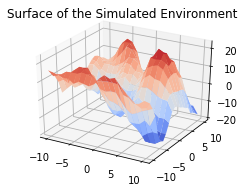

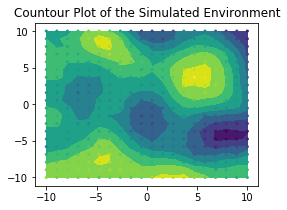

Environment initialized with bounds X1: ( -10.0 , 10.0 )  X2:( -10.0 , 10.0 )


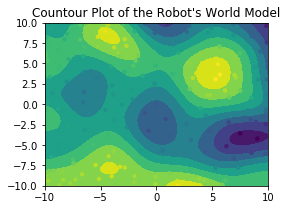

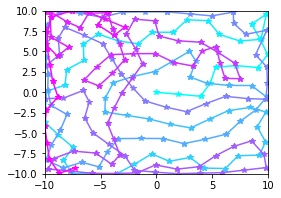

 /home/vpreston/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:138: RuntimeWarning:divide by zero encountered in divide


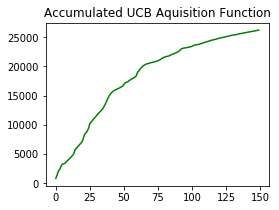

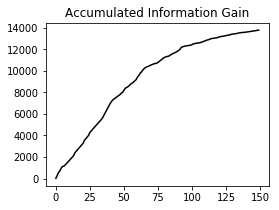

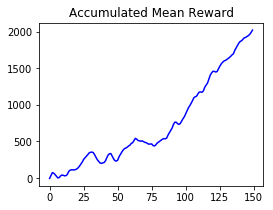

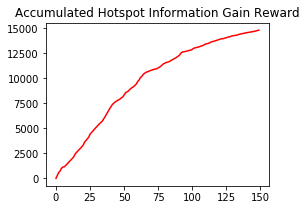

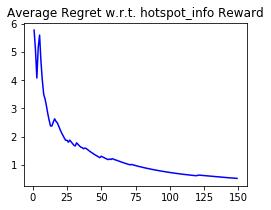

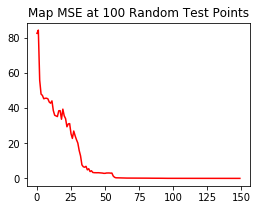

In [12]:
# Create a random enviroment sampled from a GP with an RBF kernel and specified hyperparameters, mean function 0 
# The enviorment will be constrained by a set of uniformly distributed  sample points of size NUM_PTS x NUM_PTS

''' Options include mean, info_gain, and hotspot_info'''
reward_function = 'hotspot_info'

world = Environment(ranges = (-10., 10., -10., 10.), # x1min, x1max, x2min, x2max constraints
                    NUM_PTS = 20, 
                    variance = 100.0, 
                    lengthscale = 3.0, 
                    visualize = True,
                    seed = 1)

evaluation = Evaluation(world = world, 
                        reward_function = reward_function)

# Gather some prior observations to train the kernel (optional)
ranges = (-10, 10, -10, 10)
x1observe = np.linspace(ranges[0], ranges[1], 5)
x2observe = np.linspace(ranges[2], ranges[3], 5)
x1observe, x2observe = np.meshgrid(x1observe, x2observe, sparse = False, indexing = 'xy')  
data = np.vstack([x1observe.ravel(), x2observe.ravel()]).T
observations = world.sample_value(data)

# Create the point robot
robot = Robot(sample_world = world.sample_value, 
              start_loc = (0.0, 0.0, 0.0), 
              ranges = (-10., 10., -10., 10.),
              kernel_file = None,
              kernel_dataset = None,
              prior_dataset =  None, 
              init_lengthscale = 3.0, 
              init_variance = 100.0, 
              noise = 0.05,
              path_generator = 'equal_dubins',
              frontier_size = 20, 
              horizon_length = 5.0, 
              turning_radius = 0.5, 
              sample_step = 2.0,
              evaluation = evaluation, 
              f_rew = reward_function)

robot.myopic_planner(T = 150)
robot.visualize_world_model()
robot.visualize_trajectory()
robot.plot_information()

# Implementation Notes
* Should thoroughly comment everything at some point
* TODO add "information visualization" to the system
* Change aquisition function interface
* Add reward computation interface (UCB accumulation, exploit accumulation, explore accumulation, map entropy, access final map (MSE?) [G]
* Check out MCTS (performance guarentees and implementatino) [V]

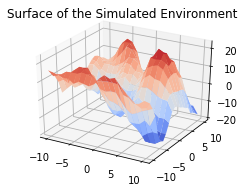

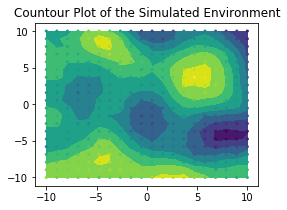

Environment initialized with bounds X1: ( -10.0 , 10.0 )  X2:( -10.0 , 10.0 )


 /home/vpreston/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning:divide by zero encountered in log
 /home/vpreston/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning:invalid value encountered in sqrt
 /home/vpreston/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning:invalid value encountered in double_scalars
 /home/vpreston/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning:divide by zero encountered in double_scalars


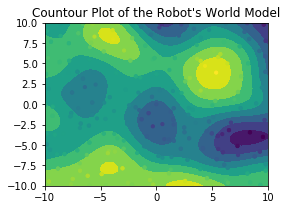

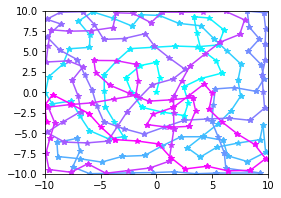

 /home/vpreston/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:138: RuntimeWarning:divide by zero encountered in divide


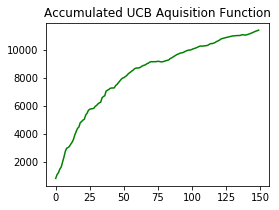

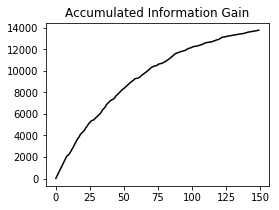

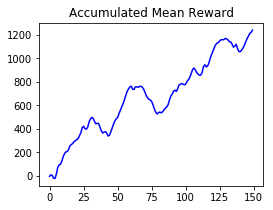

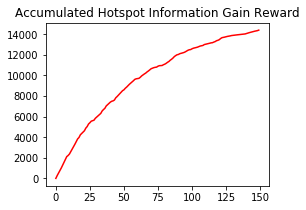

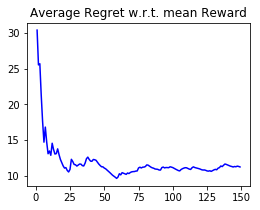

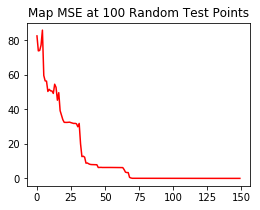

In [13]:
# Create a random enviroment sampled from a GP with an RBF kernel and specified hyperparameters, mean function 0 
# The enviorment will be constrained by a set of uniformly distributed  sample points of size NUM_PTS x NUM_PTS

''' Options include mean, info_gain, and hotspot_info'''
reward_function = 'info_gain'

world = Environment(ranges = (-10., 10., -10., 10.), # x1min, x1max, x2min, x2max constraints
                    NUM_PTS = 20, 
                    variance = 100.0, 
                    lengthscale = 3.0, 
                    visualize = True,
                    seed = 1)

evaluation = Evaluation(world)

# Gather some prior observations to train the kernel (optional)
ranges = (-10, 10, -10, 10)
x1observe = np.linspace(ranges[0], ranges[1], 5)
x2observe = np.linspace(ranges[2], ranges[3], 5)
x1observe, x2observe = np.meshgrid(x1observe, x2observe, sparse = False, indexing = 'xy')  
data = np.vstack([x1observe.ravel(), x2observe.ravel()]).T
observations = world.sample_value(data)

# Create the point robot
robot = Nonmyopic_Robot(sample_world = world.sample_value, 
              start_loc = (0.0, 0.0, 0.0), 
              ranges = (-10., 10., -10., 10.),
              kernel_file = None,
              kernel_dataset = None,
              prior_dataset =  None, 
              init_lengthscale = 3.0, 
              init_variance = 100.0, 
              noise = 0.05,
              path_generator = 'equal_dubins',
              frontier_size = 20, 
              horizon_length = 5.0, 
              turning_radius = 0.5, 
              sample_step = 2.0,
              evaluation = evaluation, 
              f_rew = reward_function,
              computation_budget = 2.0,
              rollout_length = 3)

robot.nonmyopic_planner(T = 150)
robot.visualize_world_model()
robot.visualize_trajectory()
robot.plot_information()

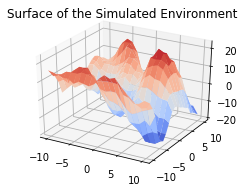

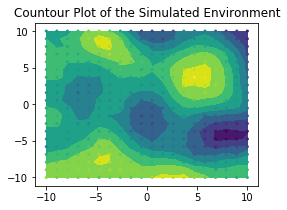

Environment initialized with bounds X1: ( -10.0 , 10.0 )  X2:( -10.0 , 10.0 )


 /home/vpreston/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning:divide by zero encountered in log
 /home/vpreston/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning:invalid value encountered in sqrt
 /home/vpreston/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning:invalid value encountered in double_scalars
 /home/vpreston/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning:divide by zero encountered in double_scalars


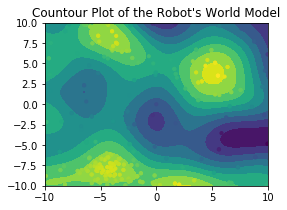

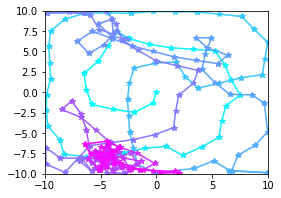

 /home/vpreston/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:138: RuntimeWarning:divide by zero encountered in divide


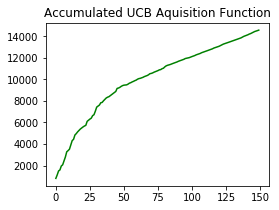

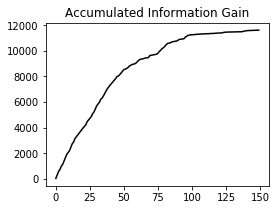

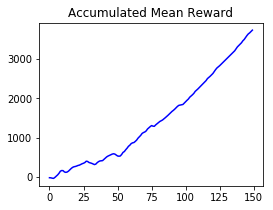

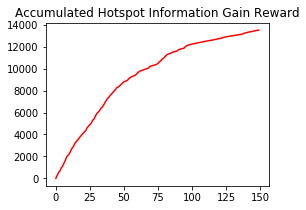

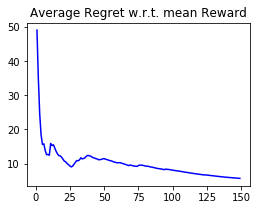

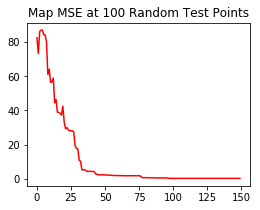

In [14]:
# Create a random enviroment sampled from a GP with an RBF kernel and specified hyperparameters, mean function 0 
# The enviorment will be constrained by a set of uniformly distributed  sample points of size NUM_PTS x NUM_PTS

''' Options include mean, info_gain, and hotspot_info'''
reward_function = 'mean'

world = Environment(ranges = (-10., 10., -10., 10.), # x1min, x1max, x2min, x2max constraints
                    NUM_PTS = 20, 
                    variance = 100.0, 
                    lengthscale = 3.0, 
                    visualize = True,
                    seed = 1)

evaluation = Evaluation(world)

# Gather some prior observations to train the kernel (optional)
ranges = (-10, 10, -10, 10)
x1observe = np.linspace(ranges[0], ranges[1], 5)
x2observe = np.linspace(ranges[2], ranges[3], 5)
x1observe, x2observe = np.meshgrid(x1observe, x2observe, sparse = False, indexing = 'xy')  
data = np.vstack([x1observe.ravel(), x2observe.ravel()]).T
observations = world.sample_value(data)

# Create the point robot
robot = Nonmyopic_Robot(sample_world = world.sample_value, 
              start_loc = (0.0, 0.0, 0.0), 
              ranges = (-10., 10., -10., 10.),
              kernel_file = None,
              kernel_dataset = None,
              prior_dataset =  None, 
              init_lengthscale = 3.0, 
              init_variance = 100.0, 
              noise = 0.05,
              path_generator = 'equal_dubins',
              frontier_size = 20, 
              horizon_length = 5.0, 
              turning_radius = 0.5, 
              sample_step = 2.0,
              evaluation = evaluation, 
              f_rew = reward_function,
              computation_budget = 2.0,
              rollout_length = 3)

robot.nonmyopic_planner(T = 150)
robot.visualize_world_model()
robot.visualize_trajectory()
robot.plot_information()

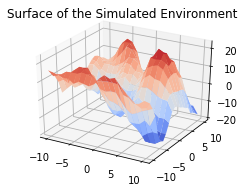

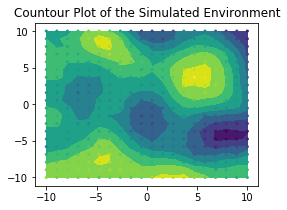

Environment initialized with bounds X1: ( -10.0 , 10.0 )  X2:( -10.0 , 10.0 )


 /home/vpreston/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning:divide by zero encountered in log
 /home/vpreston/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning:invalid value encountered in sqrt
 /home/vpreston/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning:invalid value encountered in double_scalars
 /home/vpreston/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning:divide by zero encountered in double_scalars


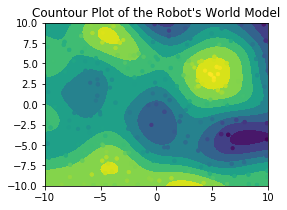

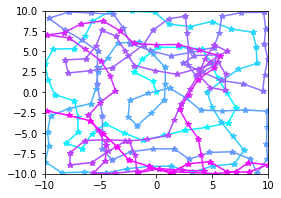

 /home/vpreston/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:138: RuntimeWarning:divide by zero encountered in divide


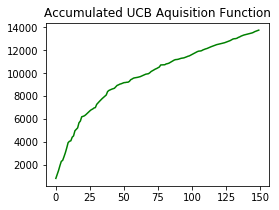

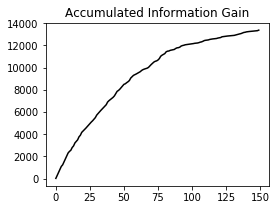

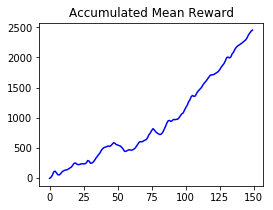

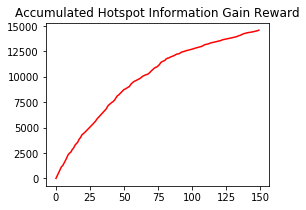

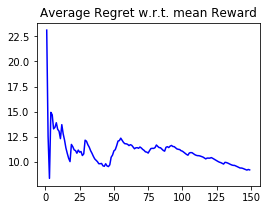

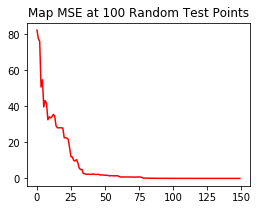

In [15]:
# Create a random enviroment sampled from a GP with an RBF kernel and specified hyperparameters, mean function 0 
# The enviorment will be constrained by a set of uniformly distributed  sample points of size NUM_PTS x NUM_PTS

''' Options include mean, info_gain, and hotspot_info'''
reward_function = 'hotspot_info'

world = Environment(ranges = (-10., 10., -10., 10.), # x1min, x1max, x2min, x2max constraints
                    NUM_PTS = 20, 
                    variance = 100.0, 
                    lengthscale = 3.0, 
                    visualize = True,
                    seed = 1)

evaluation = Evaluation(world)

# Gather some prior observations to train the kernel (optional)
ranges = (-10, 10, -10, 10)
x1observe = np.linspace(ranges[0], ranges[1], 5)
x2observe = np.linspace(ranges[2], ranges[3], 5)
x1observe, x2observe = np.meshgrid(x1observe, x2observe, sparse = False, indexing = 'xy')  
data = np.vstack([x1observe.ravel(), x2observe.ravel()]).T
observations = world.sample_value(data)

# Create the point robot
robot = Nonmyopic_Robot(sample_world = world.sample_value, 
              start_loc = (0.0, 0.0, 0.0), 
              ranges = (-10., 10., -10., 10.),
              kernel_file = None,
              kernel_dataset = None,
              prior_dataset =  None, 
              init_lengthscale = 3.0, 
              init_variance = 100.0, 
              noise = 0.05,
              path_generator = 'equal_dubins',
              frontier_size = 20, 
              horizon_length = 5.0, 
              turning_radius = 0.5, 
              sample_step = 2.0,
              evaluation = evaluation, 
              f_rew = reward_function,
              computation_budget = 2.0,
              rollout_length = 3)

robot.nonmyopic_planner(T = 150)
robot.visualize_world_model()
robot.visualize_trajectory()
robot.plot_information()